# Neural Networks Made Simple with PyTorch

By: Zack Malone, Data Scientist / Cloud Data Engineer 

After building a neural network from scratch, let's see how much easier it is using PyTorch, a modern deep learning library. This implementation will highlight the same concepts but with significantly less code.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure plots
# print("Available styles:", plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid", font_scale=1.2)

# 1. Generate Synthetic Data

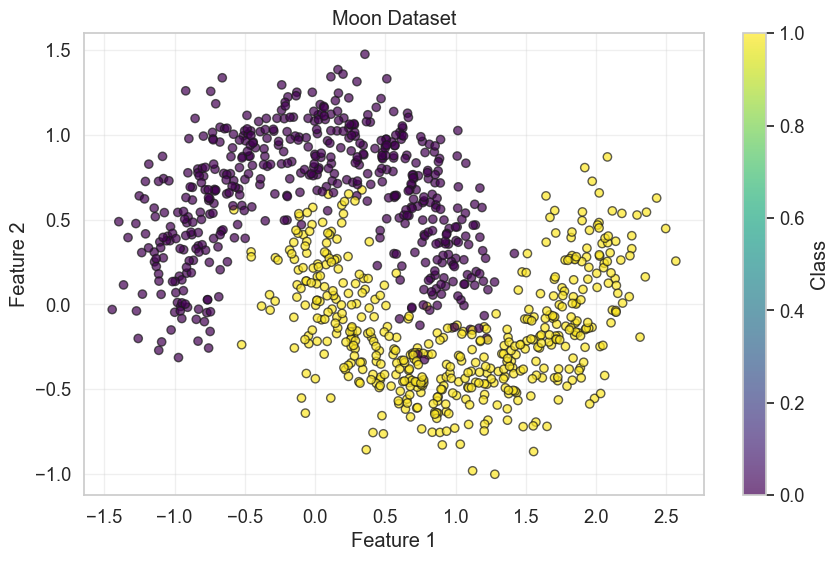

In [2]:
def generate_data(n_samples=1000):
    """Generate the same moon dataset we used before"""
    X, y = make_moons(n_samples=n_samples, noise=0.2, random_state=42)
    return X, y

# Generate and visualize the data
X, y = generate_data(1000)

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', alpha=0.7)
plt.title('Moon Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.grid(True, alpha=0.3)
plt.show()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# 2. Define Neural Network Model in PyTorch

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation=nn.Tanh()):
        """
        Initialize a neural network with configurable layer sizes and activation
        
        Parameters:
        -----------
        input_size : int
            Number of input features
        hidden_sizes : list
            List of hidden layer sizes
        output_size : int
            Number of output units
        activation : torch.nn module
            Activation function to use
        """
        super(NeuralNetwork, self).__init__()
        
        # Store configuration for reference
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation_name = activation.__class__.__name__
        
        # Create a list of layers
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(activation)
        
        # Additional hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(activation)
        
        # Final hidden layer to output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        layers.append(nn.Sigmoid())  # Output activation for binary classification
        
        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)
        
        # Print model summary
        print(f"Created neural network with architecture: {input_size} -> {' -> '.join(map(str, hidden_sizes))} -> {output_size}")
        print(f"Hidden activation: {self.activation_name}, Output activation: Sigmoid")
    
    def forward(self, x):
        """Forward pass through the network"""
        return self.model(x)
    
    def predict(self, x):
        """Predict class labels (0 or 1)"""
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():
            outputs = self.forward(x)
            predictions = (outputs >= 0.5).float()
        return predictions

# Train Different Model Configurations

In [4]:
def train_model(model, X_train, y_train, X_test, y_test, learning_rate=0.01, 
                epochs=500, batch_size=32, optimizer_name='Adam'):
    """
    Train a neural network and visualize the learning process
    
    Parameters:
    -----------
    model : NeuralNetwork
        The model to train
    X_train, y_train : torch.Tensor
        Training data
    X_test, y_test : torch.Tensor
        Test data
    learning_rate : float
        Learning rate for optimizer
    epochs : int
        Number of training epochs
    batch_size : int
        Size of mini-batches
    optimizer_name : str
        Name of optimizer to use ('Adam', 'SGD', or 'RMSprop')
    
    Returns:
    --------
    dict
        Training history
    """
    # Define loss function (binary cross entropy)
    criterion = nn.BCELoss()
    
    # Select optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Optimizer {optimizer_name} not recognized")
    
    # Track training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epochs': []
    }
    
    # Training checkpoints for visualization
    checkpoints = [0, 10, 25, 100, 250, epochs-1]  # Same as our custom NN
    decision_boundaries = {}
    
    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        
        # Mini-batch training
        indices = torch.randperm(X_train.size(0))
        batch_losses = []
        
        for i in range(0, X_train.size(0), batch_size):
            # Get mini-batch indices
            batch_idx = indices[i:i + batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # Calculate training metrics
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            train_outputs = model(X_train)
            train_loss = criterion(train_outputs, y_train).item()
            train_preds = (train_outputs >= 0.5).float()
            train_accuracy = (train_preds == y_train).float().mean().item()
            
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test).item()
            val_preds = (val_outputs >= 0.5).float()
            val_accuracy = (val_preds == y_test).float().mean().item()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)
        history['epochs'].append(epoch)
        
        # Print progress
        if epoch % 50 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}, acc: {train_accuracy:.4f} | "
                  f"Val loss: {val_loss:.4f}, acc: {val_accuracy:.4f}")
            
        # Save decision boundary for visualization
        if epoch in checkpoints:
            decision_boundaries[epoch] = model.predict(torch.FloatTensor(X)).detach().numpy()
    
    # Plot decision boundaries at different epochs
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()
    
    # Generate grid for decision boundary visualization
    h = 0.02  # Step size
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    for i, epoch in enumerate(checkpoints):
        # Make predictions on the meshgrid
        model.eval()
        with torch.no_grad():
            grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
            Z = model.predict(grid_tensor).detach().numpy()
            Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        axs[i].contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
        axs[i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', alpha=0.7)
        axs[i].set_title(f'Epoch {epoch}')
        axs[i].set_xlim(x_min, x_max)
        axs[i].set_ylim(y_min, y_max)
        
    plt.tight_layout()
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['epochs'], history['train_loss'], 'b-', label='Training Loss')
    plt.plot(history['epochs'], history['val_loss'], 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['epochs'], history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(history['epochs'], history['val_acc'], 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return history

# 4. Compare Different Network Configurations


=== Training Baseline (Small) ===
Created neural network with architecture: 2 -> 8 -> 1
Hidden activation: Tanh, Output activation: Sigmoid
Epoch 1/300 - Train loss: 0.4928, acc: 0.7500 | Val loss: 0.5215, acc: 0.7000
Epoch 51/300 - Train loss: 0.1088, acc: 0.9650 | Val loss: 0.0782, acc: 0.9950
Epoch 101/300 - Train loss: 0.0883, acc: 0.9663 | Val loss: 0.0554, acc: 0.9900
Epoch 151/300 - Train loss: 0.0829, acc: 0.9700 | Val loss: 0.0516, acc: 0.9800
Epoch 201/300 - Train loss: 0.0804, acc: 0.9700 | Val loss: 0.0466, acc: 0.9850
Epoch 251/300 - Train loss: 0.0777, acc: 0.9700 | Val loss: 0.0516, acc: 0.9750
Epoch 300/300 - Train loss: 0.0749, acc: 0.9712 | Val loss: 0.0457, acc: 0.9850


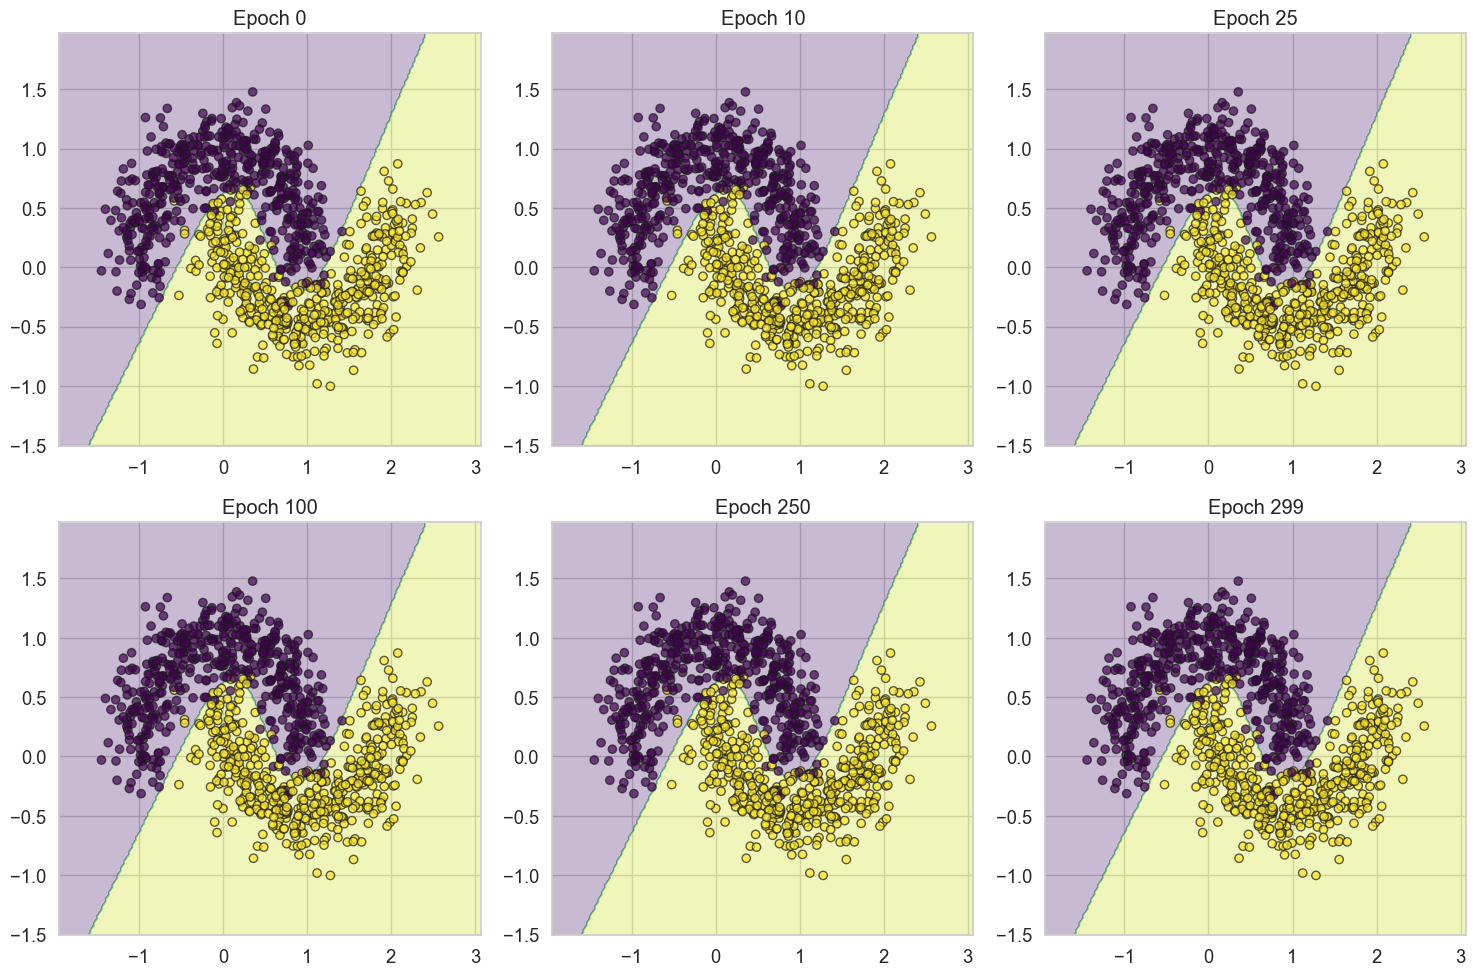

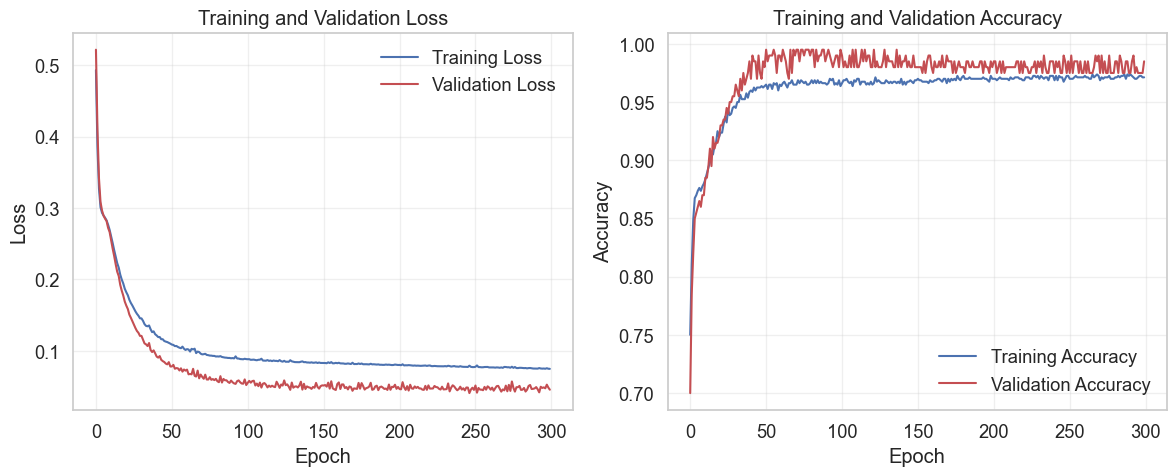


=== Training Deep Network ===
Created neural network with architecture: 2 -> 8 -> 8 -> 8 -> 1
Hidden activation: Tanh, Output activation: Sigmoid
Epoch 1/300 - Train loss: 0.4409, acc: 0.8037 | Val loss: 0.4584, acc: 0.7700
Epoch 51/300 - Train loss: 0.0776, acc: 0.9675 | Val loss: 0.0547, acc: 0.9750
Epoch 101/300 - Train loss: 0.0752, acc: 0.9712 | Val loss: 0.0475, acc: 0.9800
Epoch 151/300 - Train loss: 0.0655, acc: 0.9750 | Val loss: 0.0520, acc: 0.9850
Epoch 201/300 - Train loss: 0.0648, acc: 0.9725 | Val loss: 0.0491, acc: 0.9650
Epoch 251/300 - Train loss: 0.0567, acc: 0.9775 | Val loss: 0.0408, acc: 0.9850
Epoch 300/300 - Train loss: 0.0549, acc: 0.9775 | Val loss: 0.0500, acc: 0.9800


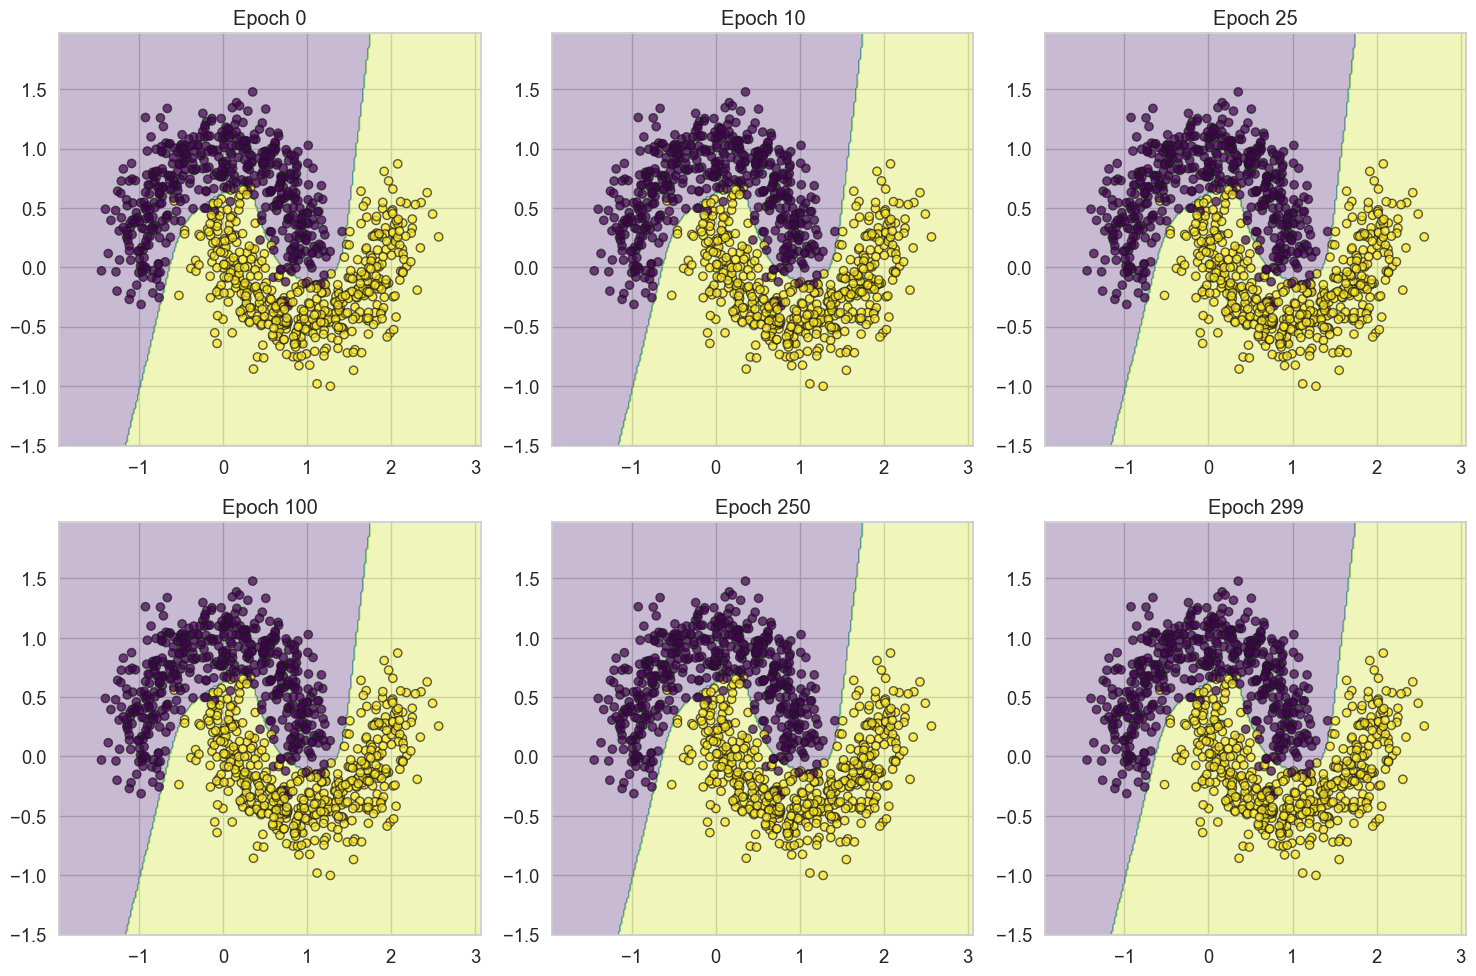

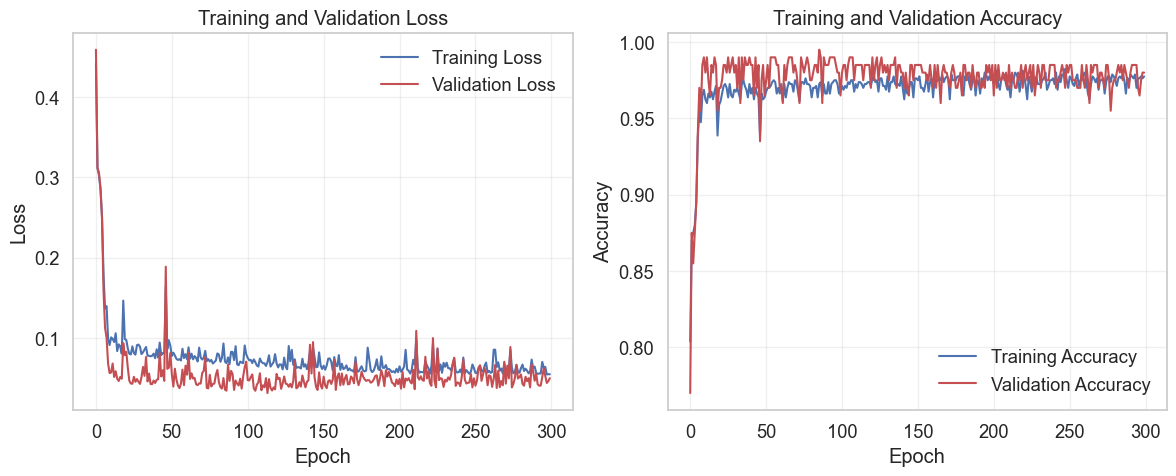


=== Training Wide Network ===
Created neural network with architecture: 2 -> 32 -> 1
Hidden activation: Tanh, Output activation: Sigmoid
Epoch 1/300 - Train loss: 0.3270, acc: 0.8475 | Val loss: 0.3470, acc: 0.8300
Epoch 51/300 - Train loss: 0.0831, acc: 0.9688 | Val loss: 0.0541, acc: 0.9950
Epoch 101/300 - Train loss: 0.0678, acc: 0.9737 | Val loss: 0.0492, acc: 0.9900
Epoch 151/300 - Train loss: 0.0674, acc: 0.9750 | Val loss: 0.0384, acc: 0.9950
Epoch 201/300 - Train loss: 0.0627, acc: 0.9762 | Val loss: 0.0503, acc: 0.9850
Epoch 251/300 - Train loss: 0.0680, acc: 0.9663 | Val loss: 0.0616, acc: 0.9700
Epoch 300/300 - Train loss: 0.0595, acc: 0.9775 | Val loss: 0.0441, acc: 0.9900


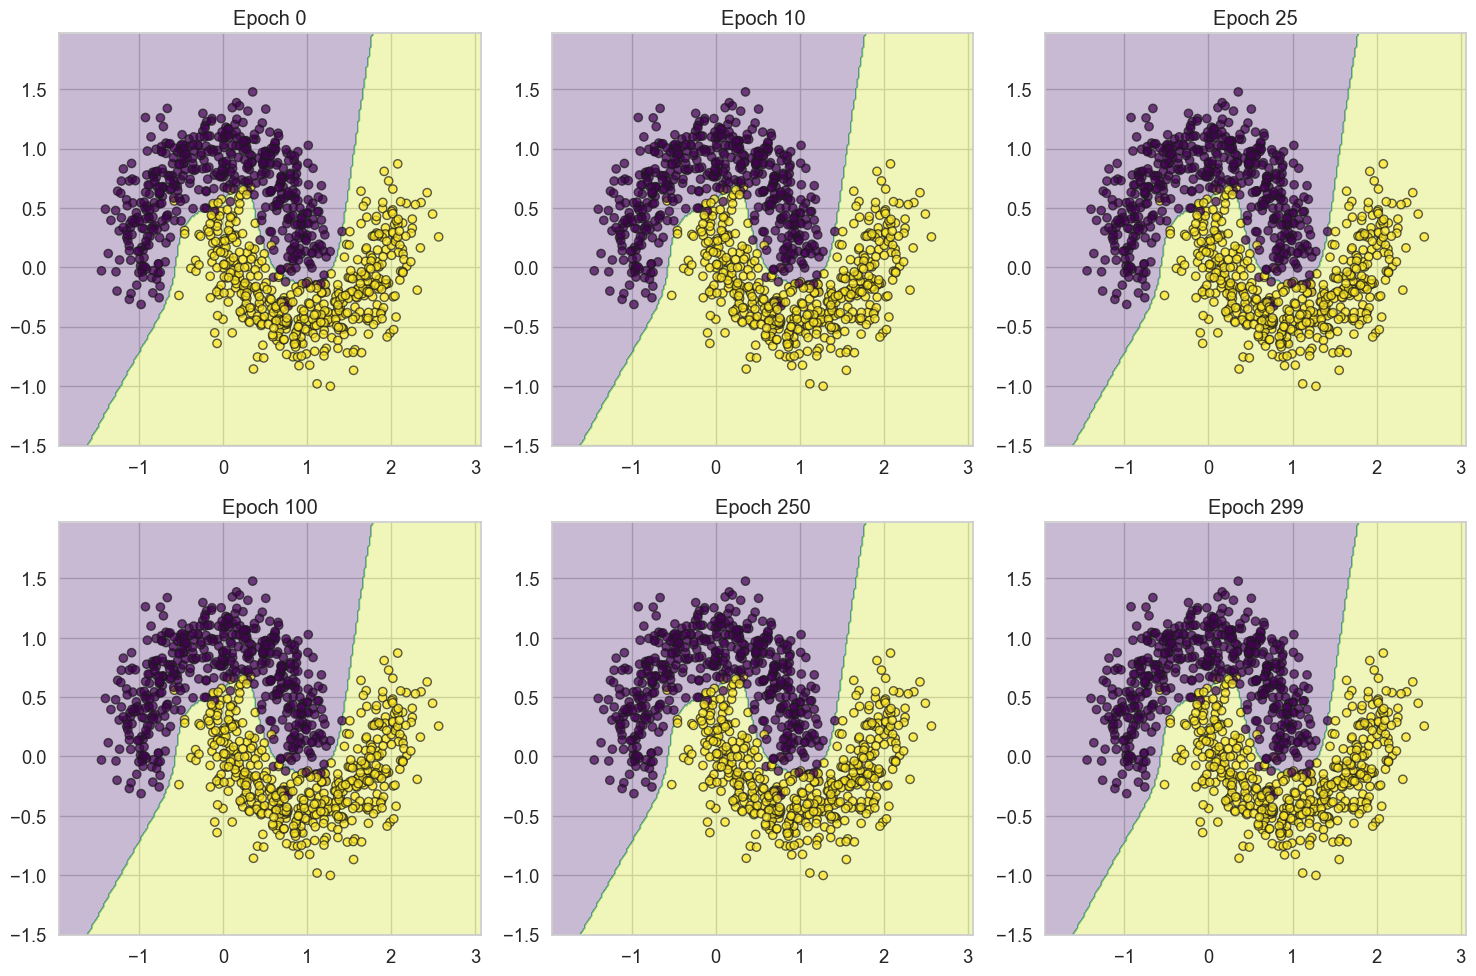

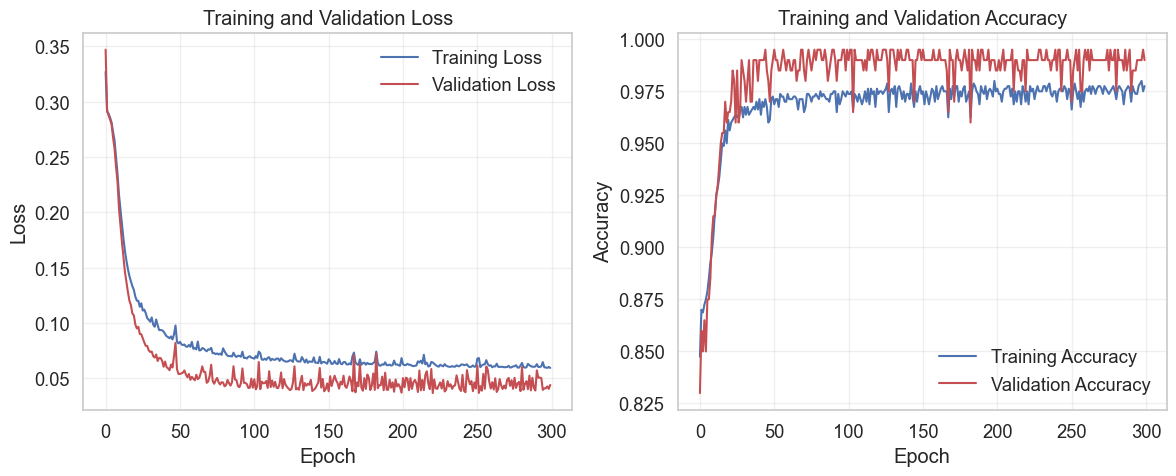


=== Training ReLU Activation ===
Created neural network with architecture: 2 -> 16 -> 8 -> 1
Hidden activation: ReLU, Output activation: Sigmoid
Epoch 1/300 - Train loss: 0.5117, acc: 0.5000 | Val loss: 0.5222, acc: 0.5000
Epoch 51/300 - Train loss: 0.0656, acc: 0.9725 | Val loss: 0.0372, acc: 0.9900
Epoch 101/300 - Train loss: 0.0612, acc: 0.9787 | Val loss: 0.0362, acc: 0.9900
Epoch 151/300 - Train loss: 0.0606, acc: 0.9762 | Val loss: 0.0477, acc: 0.9850
Epoch 201/300 - Train loss: 0.0713, acc: 0.9712 | Val loss: 0.0321, acc: 0.9850
Epoch 251/300 - Train loss: 0.0657, acc: 0.9737 | Val loss: 0.0289, acc: 0.9950
Epoch 300/300 - Train loss: 0.0628, acc: 0.9725 | Val loss: 0.0453, acc: 0.9850


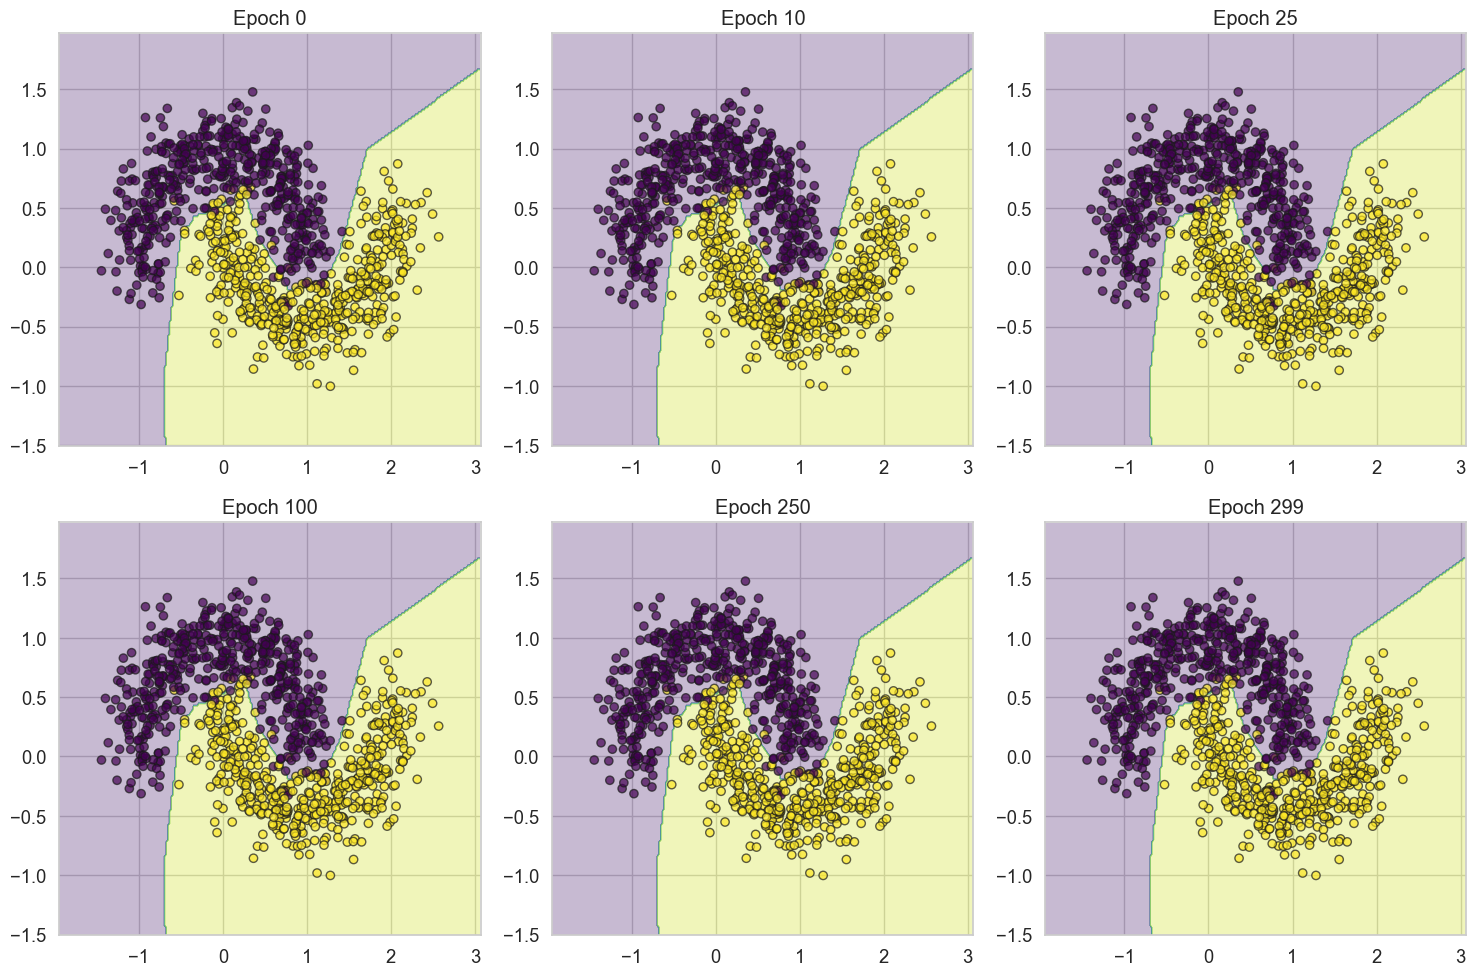

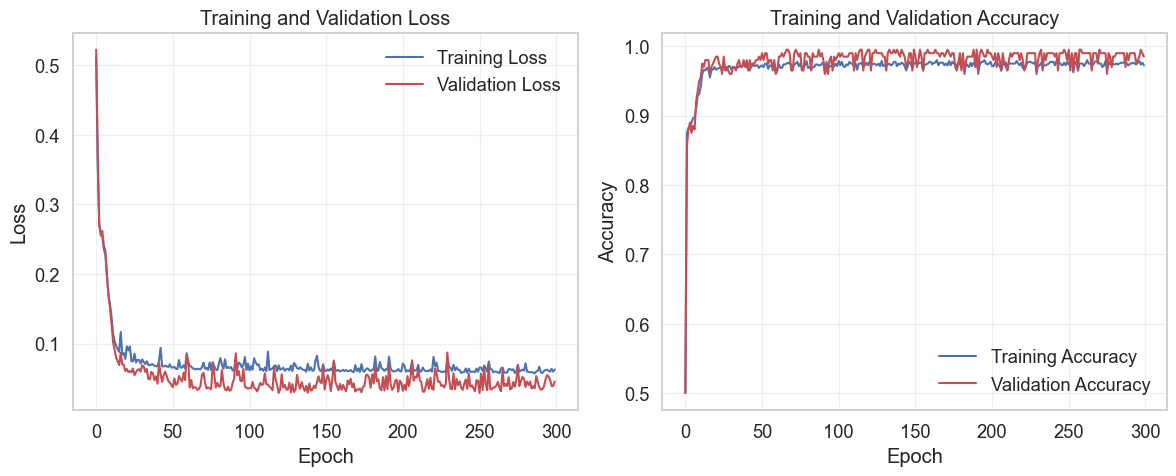


=== Training SGD Optimizer ===
Created neural network with architecture: 2 -> 16 -> 8 -> 1
Hidden activation: Tanh, Output activation: Sigmoid
Epoch 1/300 - Train loss: 0.5142, acc: 0.8225 | Val loss: 0.5271, acc: 0.7850
Epoch 51/300 - Train loss: 0.0940, acc: 0.9650 | Val loss: 0.0689, acc: 0.9850
Epoch 101/300 - Train loss: 0.0755, acc: 0.9712 | Val loss: 0.0515, acc: 0.9750
Epoch 151/300 - Train loss: 0.0718, acc: 0.9737 | Val loss: 0.0372, acc: 0.9950
Epoch 201/300 - Train loss: 0.0673, acc: 0.9725 | Val loss: 0.0379, acc: 0.9900
Epoch 251/300 - Train loss: 0.0661, acc: 0.9725 | Val loss: 0.0460, acc: 0.9900
Epoch 300/300 - Train loss: 0.0686, acc: 0.9750 | Val loss: 0.0376, acc: 0.9950


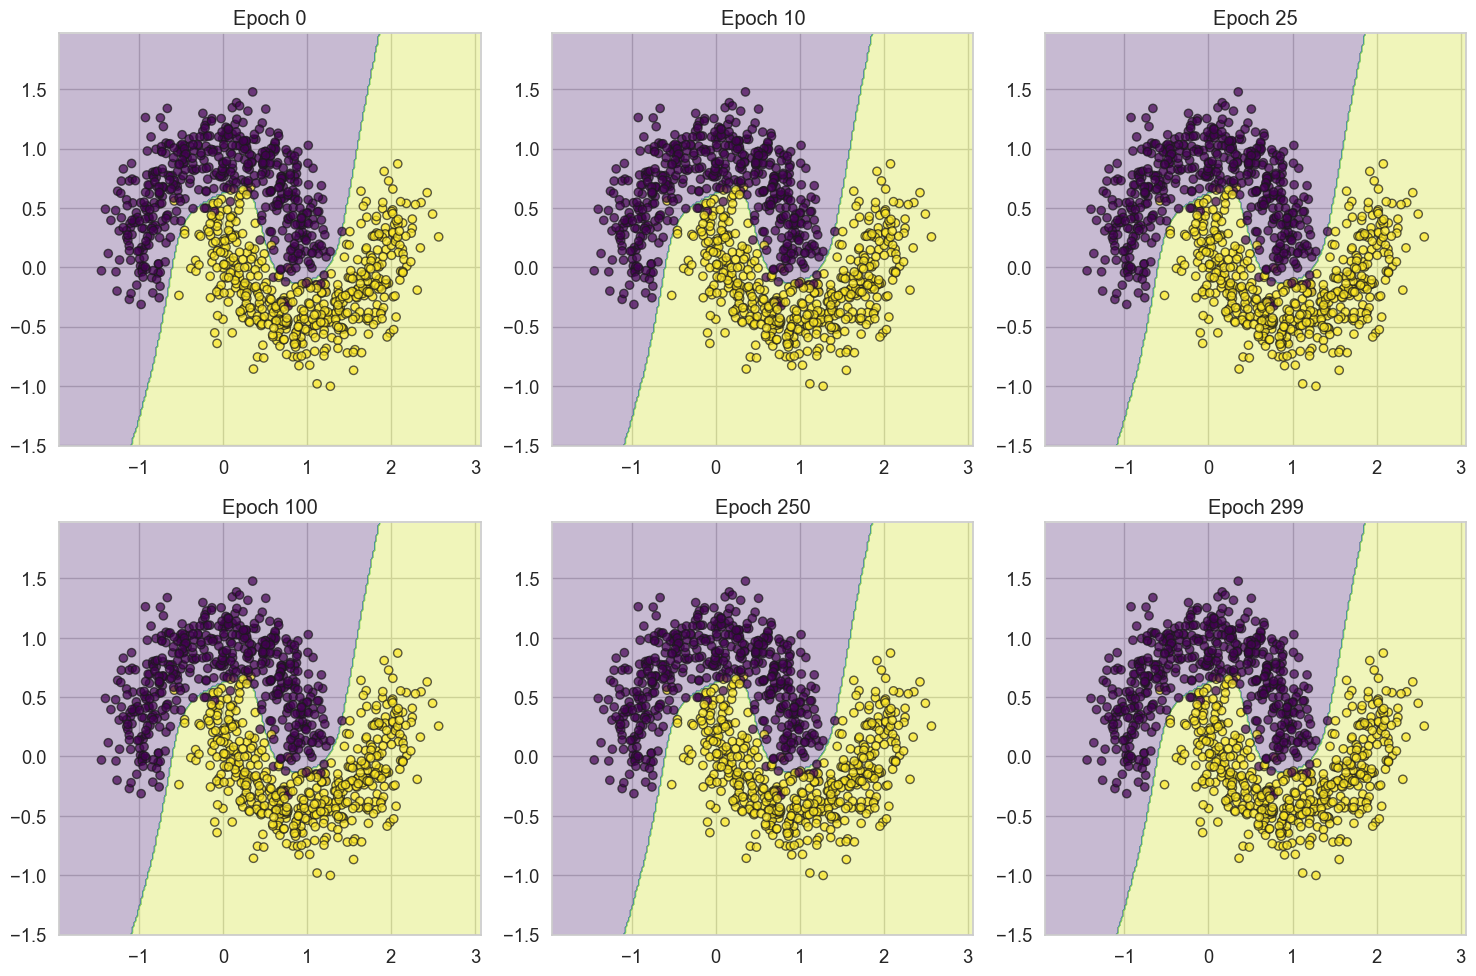

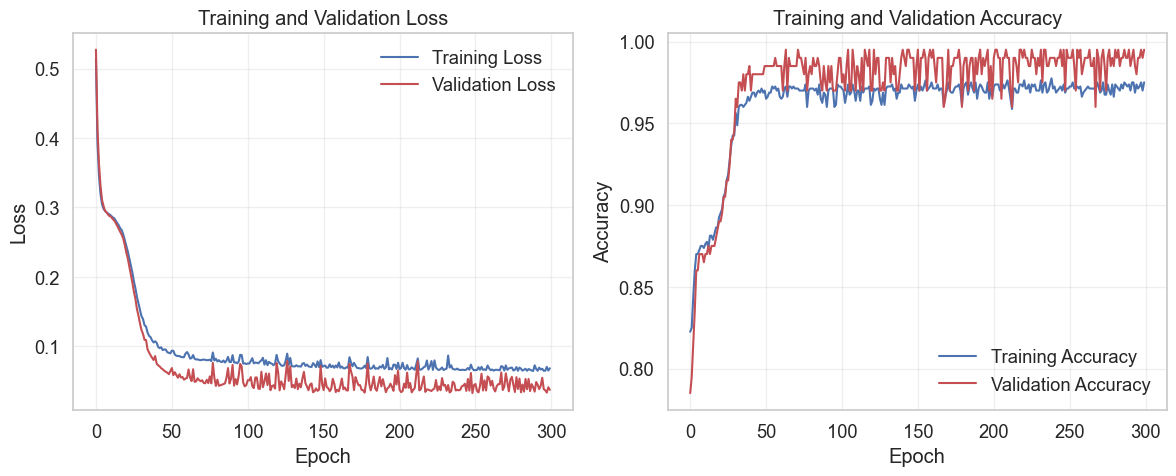


=== Model Comparison ===
Model                Architecture         Activation Optimizer  Train Acc  Val Acc   
--------------------------------------------------------------------------------
Baseline (Small)     2 -> 8 -> 1          Tanh       Adam       0.9712    0.9850
Deep Network         2 -> 8 -> 8 -> 8 -> 1 Tanh       Adam       0.9775    0.9800
Wide Network         2 -> 32 -> 1         Tanh       Adam       0.9775    0.9900
ReLU Activation      2 -> 16 -> 8 -> 1    ReLU       Adam       0.9725    0.9850
SGD Optimizer        2 -> 16 -> 8 -> 1    Tanh       SGD        0.9750    0.9950


In [7]:
# Define configurations to test
configurations = [
    {
        'name': 'Baseline (Small)',
        'hidden_sizes': [8],
        'activation': nn.Tanh(),
        'learning_rate': 0.01,
        'optimizer': 'Adam',
        'epochs': 300
    },
    {
        'name': 'Deep Network',
        'hidden_sizes': [8, 8, 8],
        'activation': nn.Tanh(),
        'learning_rate': 0.01,
        'optimizer': 'Adam',
        'epochs': 300
    },
    {
        'name': 'Wide Network',
        'hidden_sizes': [32],
        'activation': nn.Tanh(),
        'learning_rate': 0.01,
        'optimizer': 'Adam',
        'epochs': 300
    },
    {
        'name': 'ReLU Activation',
        'hidden_sizes': [16, 8],
        'activation': nn.ReLU(),
        'learning_rate': 0.01,
        'optimizer': 'Adam',
        'epochs': 300
    },
    {
        'name': 'SGD Optimizer',
        'hidden_sizes': [16, 8],
        'activation': nn.Tanh(),
        'learning_rate': 0.01,
        'optimizer': 'SGD',
        'epochs': 300
    }
]

# Train and evaluate each configuration
results = []

for config in configurations:
    print(f"\n=== Training {config['name']} ===")
    
    # Create model
    model = NeuralNetwork(
        input_size=2,
        hidden_sizes=config['hidden_sizes'],
        output_size=1,
        activation=config['activation']
    )
    
    # Train model
    history = train_model(
        model=model,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        X_test=X_test_tensor,
        y_test=y_test_tensor,
        learning_rate=config['learning_rate'],
        epochs=config['epochs'],
        optimizer_name=config['optimizer']
    )
    
    # Calculate final metrics
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    
    # Store results
    results.append({
        'name': config['name'],
        'train_acc': final_train_acc,
        'val_acc': final_val_acc,
        'architecture': f"2 -> {' -> '.join(map(str, config['hidden_sizes']))} -> 1",
        'activation': config['activation'].__class__.__name__,
        'optimizer': config['optimizer']
    })

# Display comparison table
print("\n=== Model Comparison ===")
print(f"{'Model':<20} {'Architecture':<20} {'Activation':<10} {'Optimizer':<10} {'Train Acc':<10} {'Val Acc':<10}")
print("-" * 80)

for result in results:
    print(f"{result['name']:<20} {result['architecture']:<20} {result['activation']:<10} "
          f"{result['optimizer']:<10} {result['train_acc']:.4f}    {result['val_acc']:.4f}")

# 5. Visualize Weight Distributions (PyTorch Equivalent)

Created neural network with architecture: 2 -> 16 -> 8 -> 1
Hidden activation: Tanh, Output activation: Sigmoid
Epoch 1/300 - Train loss: 0.3331, acc: 0.8562 | Val loss: 0.3441, acc: 0.8300
Epoch 51/300 - Train loss: 0.0714, acc: 0.9750 | Val loss: 0.0398, acc: 0.9850
Epoch 101/300 - Train loss: 0.0759, acc: 0.9737 | Val loss: 0.0339, acc: 0.9850
Epoch 151/300 - Train loss: 0.0641, acc: 0.9775 | Val loss: 0.0429, acc: 0.9900
Epoch 201/300 - Train loss: 0.0574, acc: 0.9787 | Val loss: 0.0385, acc: 0.9900
Epoch 251/300 - Train loss: 0.0555, acc: 0.9775 | Val loss: 0.0426, acc: 0.9850
Epoch 300/300 - Train loss: 0.0536, acc: 0.9787 | Val loss: 0.0522, acc: 0.9750


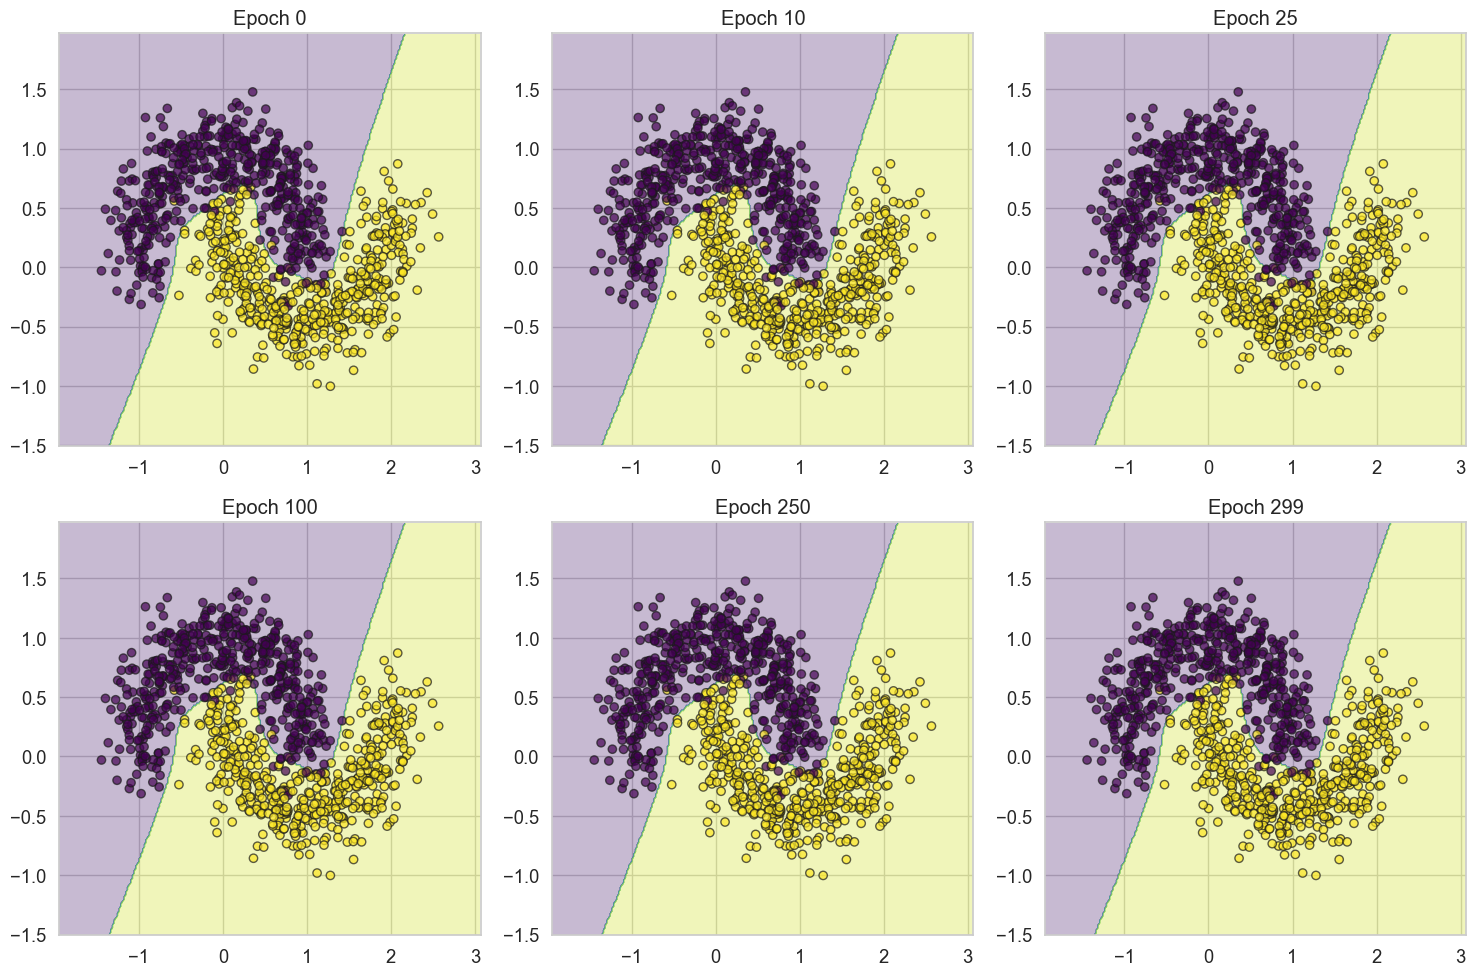

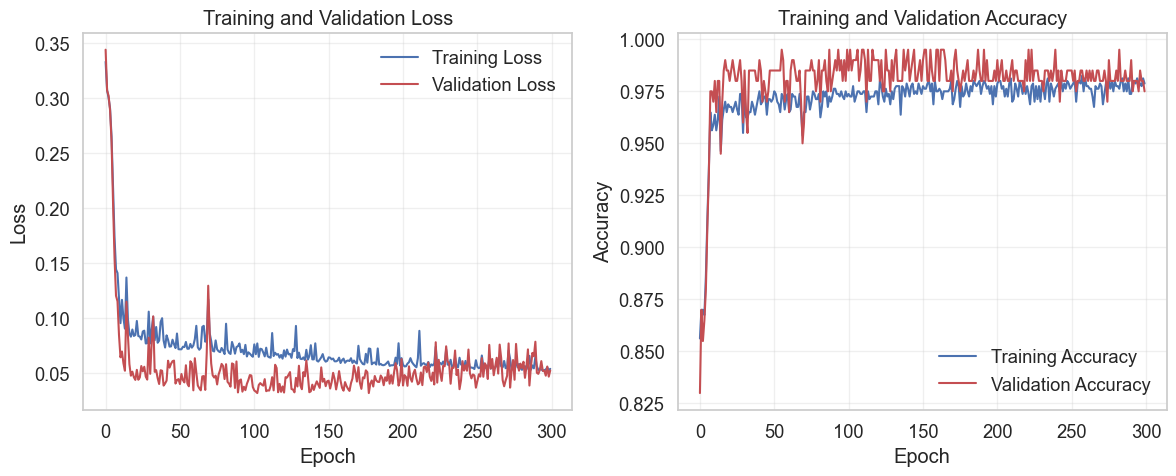

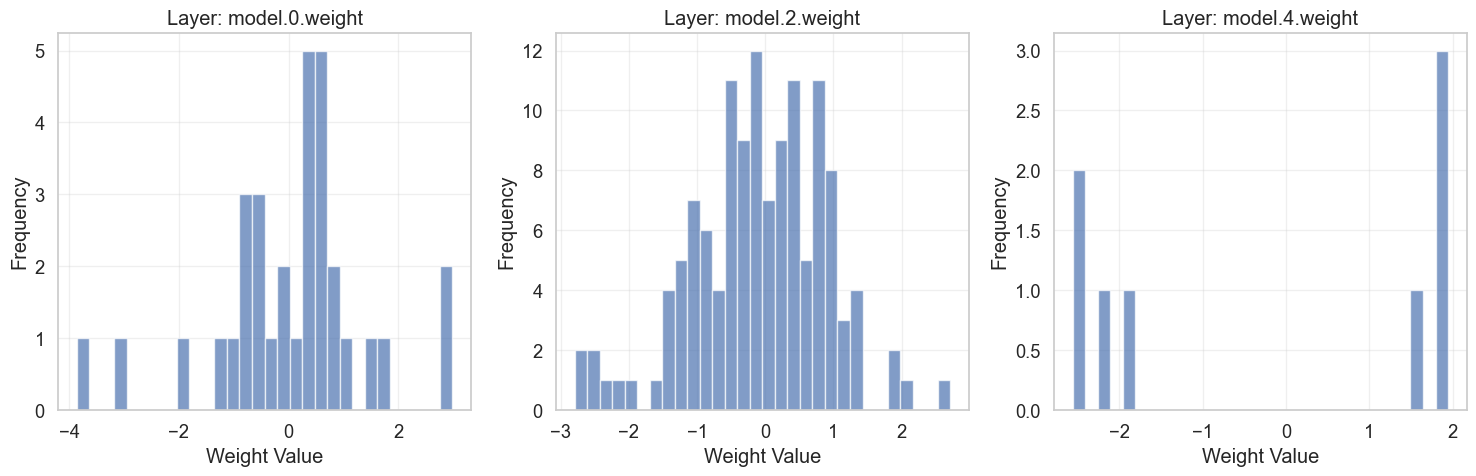

In [6]:
def visualize_model_weights(model):
    """Visualize the weights of a PyTorch model"""
    # Collect weights from all linear layers
    weights = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.detach().numpy().flatten())
            layer_names.append(name)
    
    # Create subplots
    fig, axs = plt.subplots(1, len(weights), figsize=(15, 5))
    
    # If only one layer, wrap axs in a list
    if len(weights) == 1:
        axs = [axs]
    
    # Plot weight histograms
    for i, (w, name) in enumerate(zip(weights, layer_names)):
        axs[i].hist(w, bins=30, alpha=0.7)
        axs[i].set_title(f'Layer: {name}')
        axs[i].set_xlabel('Weight Value')
        axs[i].set_ylabel('Frequency')
        axs[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize weights for the baseline model
baseline_model = NeuralNetwork(
    input_size=2,
    hidden_sizes=[16, 8],
    output_size=1,
    activation=nn.Tanh()
)

# Train the model first
train_model(
    model=baseline_model,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    epochs=300
)

# Visualize the trained weights
visualize_model_weights(baseline_model)


## Key Concepts Illustrated in PyTorch Implementation

1. **Model Creation**:
   - PyTorch's `nn.Module` handles all the initialization that we did manually
   - Weight initialization happens automatically with good defaults
   - Neural network layers are defined with `nn.Linear` instead of our manual matrix operations

2. **Activation Functions**:
   - Available as built-in modules like `nn.ReLU()`, `nn.Tanh()`, `nn.Sigmoid()`
   - No need to implement derivatives - PyTorch handles backpropagation automatically

3. **Forward Propagation**:
   - The `forward()` method replaces our detailed matrix calculation code
   - Data flows through layers automatically with proper shape handling

4. **Loss Functions**:
   - Built-in implementations like `nn.BCELoss()` replace our custom loss functions
   - No need to derive gradients manually

5. **Backpropagation**:
   - Handled by PyTorch's autograd system with just `loss.backward()`
   - No manual derivative calculations or chain rule application needed

6. **Optimizers**:
   - Pre-implemented algorithms like Adam, SGD, and RMSprop
   - Weight updates happen automatically with `optimizer.step()`

7. **Batching**:
   - Mini-batch training is handled with simple slicing operations
   - No need to manually implement batch processing

8. **Model Evaluation**:
   - Easy switching between training and evaluation modes with `model.train()` and `model.eval()`
   - The `with torch.no_grad()` context prevents gradient calculation during inference

## Advantages of Using PyTorch

1. **Less Code**: Our PyTorch implementation is significantly shorter and more readable
2. **Automatic Differentiation**: No need to implement backpropagation manually
3. **GPU Acceleration**: Just add `.to('cuda')` to run on GPU (not shown here for simplicity)
4. **Ecosystem Support**: Easy integration with more advanced techniques
5. **Debugging Tools**: Better error messages and debugging capabilities
6. **Performance**: Optimized implementations of core operations

The same concepts we built from scratch (neurons, weights, bias, activation functions, forward/backward propagation) are all present in the PyTorch version, but abstracted away to let you focus on model architecture and hyperparameters rather than implementation details.